https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=10987&end_date=2025-04-15&f=json


C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_21336\821284178.py:157: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



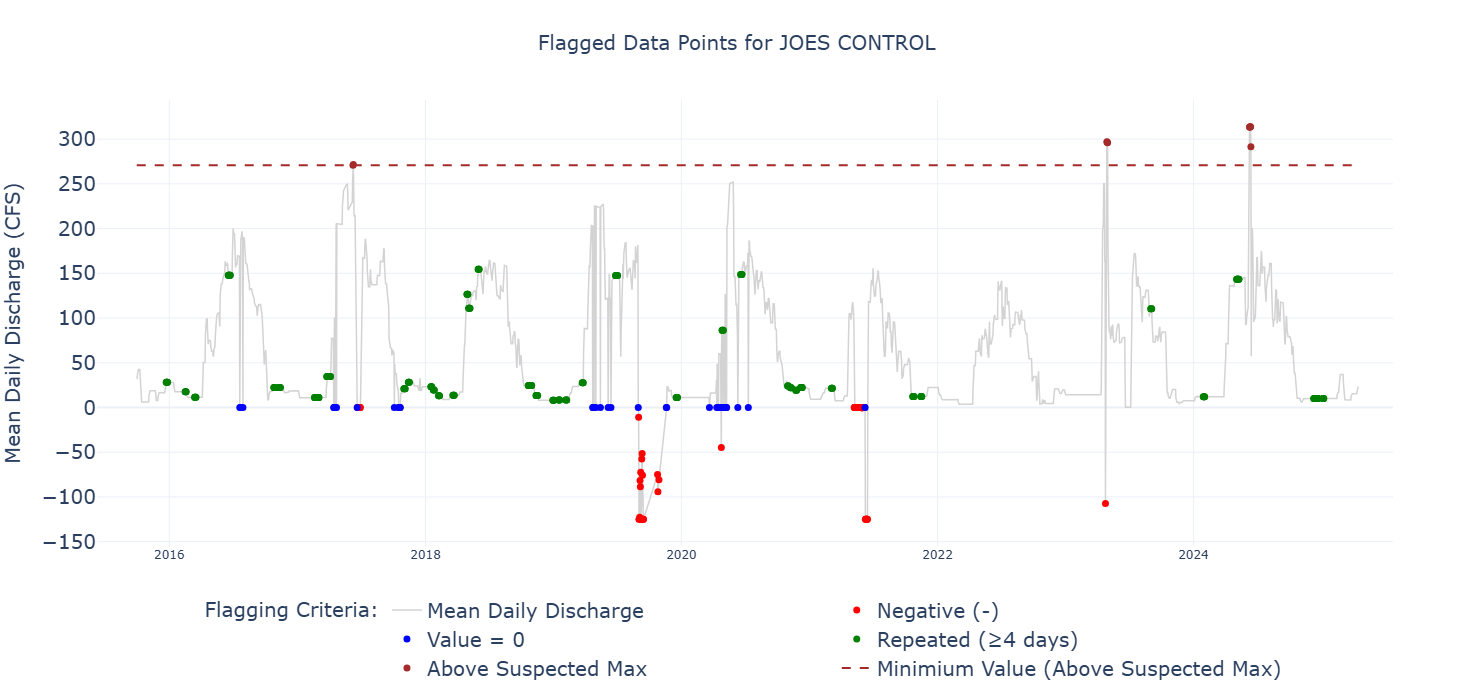

https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=3133&end_date=2025-04-15&f=json


C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_21336\821284178.py:157: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



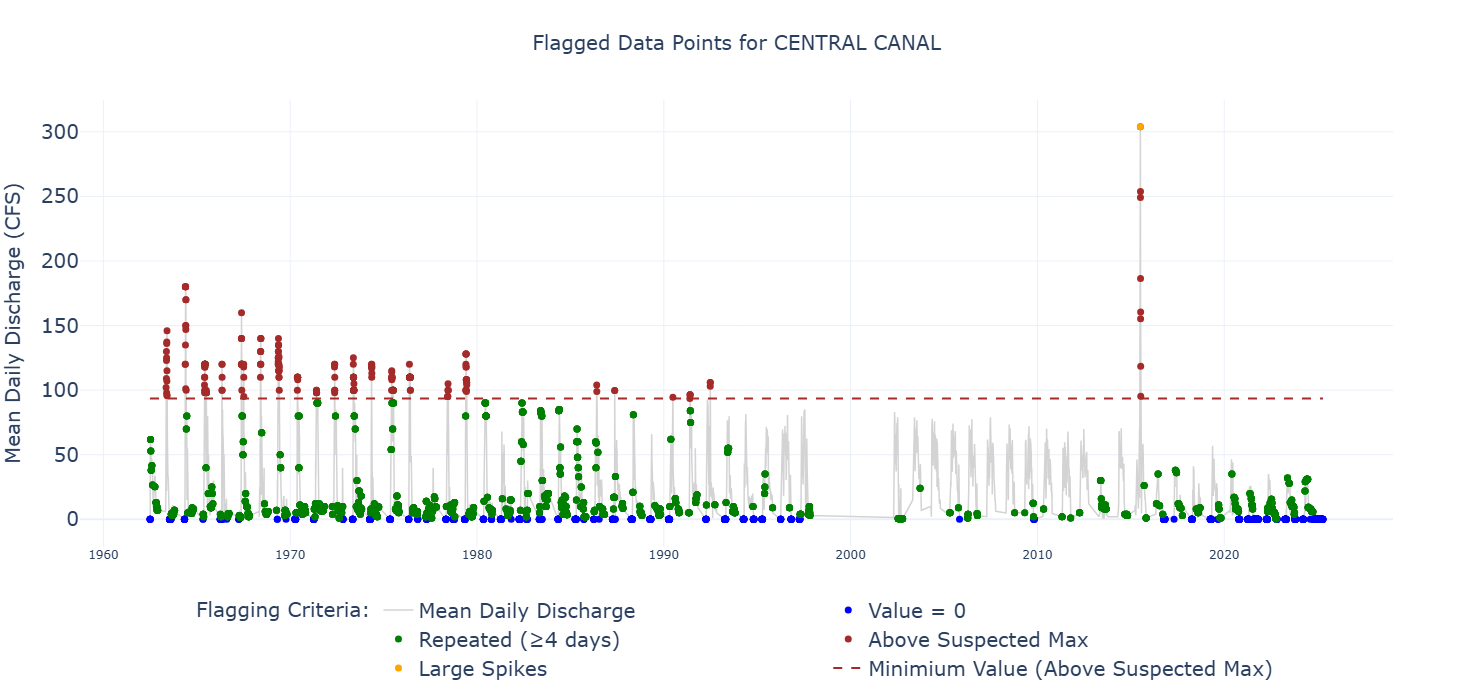

https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id=10543&end_date=2025-04-15&f=json


C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_21336\821284178.py:157: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



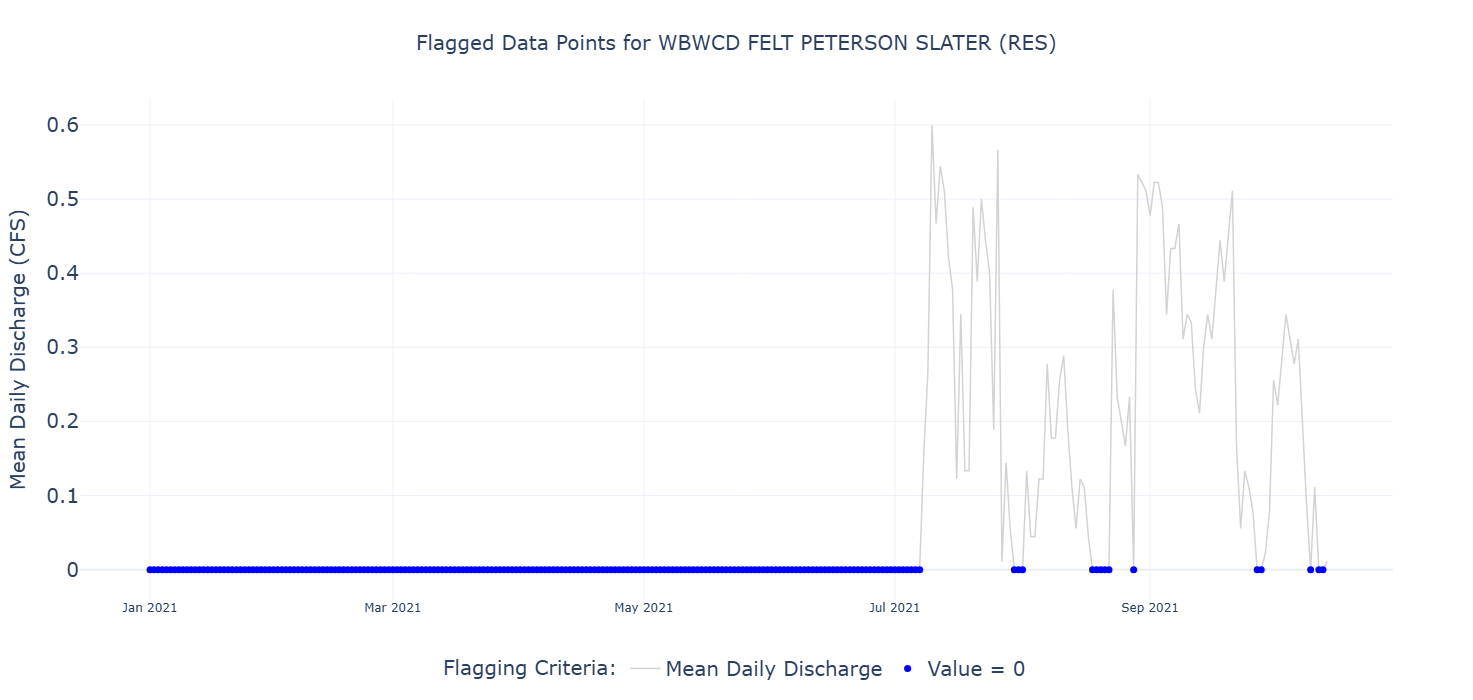

In [10]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go

# Define the UTDWR site IDs
site_ids = ["10987", "3133", "10543"]  # Add more site IDs as needed

# Loop through each site_id
for DivrtID in site_ids:
    # Define parameters
    end_date = datetime.today().strftime("%Y-%m-%d")  # Get today's date in YYYY-MM-DD format

    # Construct API URL
    api_url = f"https://www.waterrights.utah.gov/dvrtdb/daily-chart.asp?station_id={DivrtID}&end_date={end_date}&f=json"
    print(api_url)

    # Fetch data from the API
    response = requests.get(api_url)

    # Check if request was successful
    if response.status_code == 200:
        data = response.json()

        # Extract time series data
        if "data" in data:
            df = pd.DataFrame(data["data"], columns=["date", "value"])
            df.rename(columns={"date": "Date", "value": "DISCHARGE"}, inplace=True)  # Ensure correct column names

            # Add metadata as new columns
            metadata_fields = ["station_id", "station_name", "system_name", "units"]
            metadata = {field: data.get(field, "N/A") for field in metadata_fields}

            # Add missing metadata columns with default values ("N/A")
            for key, value in metadata.items():
                df[key] = value

            # Reorder columns only with existing ones
            column_order = ["Date", "DISCHARGE"]  # Start with core columns
            for field in metadata_fields:
                if field in df.columns:
                    column_order.append(field)
            df = df[column_order]

        else:
            print("Error: 'data' key not found in API response.")
            continue
    else:
        print(f"Error fetching data: {response.status_code}")
        continue

    # Convert 'DISCHARGE' to numeric, coercing errors to NaN
    df['DISCHARGE'] = pd.to_numeric(df['DISCHARGE'], errors='coerce')

    # === FLAGGING CRITERIA === #
    # Exclude 0 values when flagging for negative values
    df['FLAG_NEGATIVE'] = (df['DISCHARGE'] < 0) & (df['DISCHARGE'] != 0)

    # Exclude 0 values for "FLAG_ZERO" criteria
    df['FLAG_ZERO'] = (df['DISCHARGE'] == 0)

    # === Filter Out Non-Positive Values for Statistical Tests === #
    df_nonzero = df[df["DISCHARGE"] > 0].copy()
    
    if not df_nonzero.empty:
        # === Compute IQR Thresholds === #
        Q1, Q3 = df_nonzero["DISCHARGE"].quantile([0.25, 0.75])
        IQR = Q3 - Q1
    
        # === Compute 90th Percentile Thresholds === #
        discharge_90th_percentile = np.percentile(df_nonzero["DISCHARGE"].dropna(), 90)
    
        # === Compute the 95th Percentile Thresholds === #
        discharge_95th_percentile = np.percentile(df_nonzero["DISCHARGE"].dropna(), 95)
        
        # === Compute Rate of Change and Merge Back === #
        df_nonzero["RATE_OF_CHANGE"] = df_nonzero["DISCHARGE"].diff().abs()
        df = df.merge(df_nonzero[["Date", "RATE_OF_CHANGE"]], on="Date", how="left")
    
        # === Flag Repeated Values (4 or more in a row) === #
        df_nonzero["FLAG_REPEATED"] = df_nonzero["DISCHARGE"].groupby(
            (df_nonzero["DISCHARGE"] != df_nonzero["DISCHARGE"].shift()).cumsum()
        ).transform("count") >= 4
    
        # === Run Isolation Forest for Outlier Detection === #
        model = IsolationForest(contamination=0.05, random_state=42)
        df_nonzero["OUTLIER_IF"] = model.fit_predict(df_nonzero[["DISCHARGE"]])
        df_nonzero["OUTLIER_IF"] = df_nonzero["OUTLIER_IF"] == -1
    
        # === Compute Relative Standard Deviation for Flagging Large Spikes === #
        mean_discharge = df_nonzero["DISCHARGE"].mean()
        df["PERCENT_DEV"] = ((df["DISCHARGE"] - mean_discharge).abs() / mean_discharge) * 100
    
        # === Flag Discharges with Large Relative Deviation === #
        threshold = 1000 # Over 1000% deviation
        df["FLAG_RSD"] = (df["PERCENT_DEV"] > threshold) & (df["DISCHARGE"] != 0)
    
        # === Merge Isolation Forest and Repeated Flags Back === #
        df = df.merge(df_nonzero[["Date", "OUTLIER_IF", "FLAG_REPEATED"]], on="Date", how="left")
    else:
        # === Fallback Values for Empty or Non-Positive Series === #
        discharge_90th_percentile = 0
        discharge_95th_percentile = 0
        IQR = 0
        Q1 = Q3 = 0
        df["RATE_OF_CHANGE"] = np.nan
        df["OUTLIER_IF"] = False
        df["FLAG_REPEATED"] = False
        df["PERCENT_DEV"] = np.nan
        df["FLAG_RSD"] = False
    
    # === Flag Values > 95th Percentile Outliers, IQR Outliers Upper and Lower Bound, Flag Values Rate of Change > 90th Percentile Value  === #
    df["FLAG_Discharge"] = df["DISCHARGE"] > discharge_95th_percentile
    df["FLAG_IQR"] = (df["DISCHARGE"] < Q1 - 1.5 * IQR) | (df["DISCHARGE"] > Q3 + 1.5 * IQR)
    df["FLAG_RoC"] = df["RATE_OF_CHANGE"] > discharge_90th_percentile
    
    # === Above Max (Suspected Above Max)--only show common flagged values among the three methods (IQR, > 95th Percentile, IF) === #
    df["FLAG_ABOVE_MAX_OVERLAP"] = df["FLAG_IQR"] & df["FLAG_Discharge"] & df["OUTLIER_IF"]
    
    # === Large Spikes --only show common flagged values among the two methods (RSD,RoC) === #
    df["FLAG_LARGE_SPIKES"] = df["FLAG_RSD"] & df["FLAG_RoC"]
    
    # === Overall Flagged Record Indicator === #
    df["FLAGGED"] = df[
        ["FLAG_NEGATIVE", "FLAG_ZERO", "FLAG_REPEATED", "FLAG_ABOVE_MAX_OVERLAP", "FLAG_LARGE_SPIKES"]
    ].any(axis=1)
    

    # Define plot title
    plot_title = f"Flagged Data Points for {metadata.get('station_name', 'Station ' + DivrtID)}"

    # Define custom legend names and colors
    flag_colors = {
        'FLAG_NEGATIVE': ('red', 'Negative (-)'),
        'FLAG_ZERO': ('blue', 'Value = 0'),
        'FLAG_REPEATED': ('green', 'Repeated (≥4 days)'),
        'FLAG_ABOVE_MAX_OVERLAP': ('brown', 'Above Suspected Max'),
        'FLAG_LARGE_SPIKES': ('orange', 'Large Spikes'),
    }

    # Create plot
    fig = go.Figure()

    # Background Line (Mean Daily Discharge)
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['DISCHARGE'],
        mode='lines',
        line=dict(color='lightgray', width=1.5),
        name='Mean Daily Discharge',
        connectgaps=False
    ))

    # Add flagged points
    for flag, (color, legend_name) in flag_colors.items():
        subset = df[df[flag].fillna(False)]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset['Date'], y=subset['DISCHARGE'],
                mode='markers',
                marker=dict(color=color, size=7),
                name=legend_name
            ))

        # Add horizontal dashed line for min value of Above Max
    above_max_subset = df[df["FLAG_ABOVE_MAX_OVERLAP"].fillna(False).astype(bool)]
    if not above_max_subset.empty:
        min_above_max = above_max_subset["DISCHARGE"].min()
        fig.add_trace(go.Scatter(
            x=[df["Date"].min(), df["Date"].max()],
            y=[min_above_max, min_above_max],
            mode="lines",
            line=dict(color="brown", width=2, dash="dash"),
            name="Minimium Value (Above Suspected Max)"
        ))

    # Update layout with title and legend placement
    fig.update_layout(
        title=dict(
            text=plot_title,
            x=0.5,  # Centers the title
            font=dict(size=20)
        ),
        yaxis=dict(
            title="Mean Daily Discharge (CFS)",
            title_font=dict(size=20),
            tickfont=dict(size=20)
        ),
        legend=dict(
            orientation="h",  # Horizontal legend
            yanchor="top",
            y=-0.1,  # Moves the legend below the plot
            xanchor="center",
            x=0.5,
            title=dict(text="Flagging Criteria:", font=dict(size=20)),
            font=dict(size=20)
        ),
        template="plotly_white",
        width=1400,
        height=700
    )
        # Show the plot
    fig.show()